In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from argparse import Namespace

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
from sklearn.metrics import f1_score, accuracy_score, make_scorer, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from pyarc import CBA, TransactionDB

from autofeat import AutoFeatClassifier

In [ ]:
df = pd.read_csv('D:/Data Mining/CA/Final/banking.csv')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,...,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


Let's take a look at the dataframe's features. It appears that we don't have any missing values. We can see that almost half of the features are categorical.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

# Visualize the Data

We visualize each feature independently, to see its distribution and identify potential outliers.

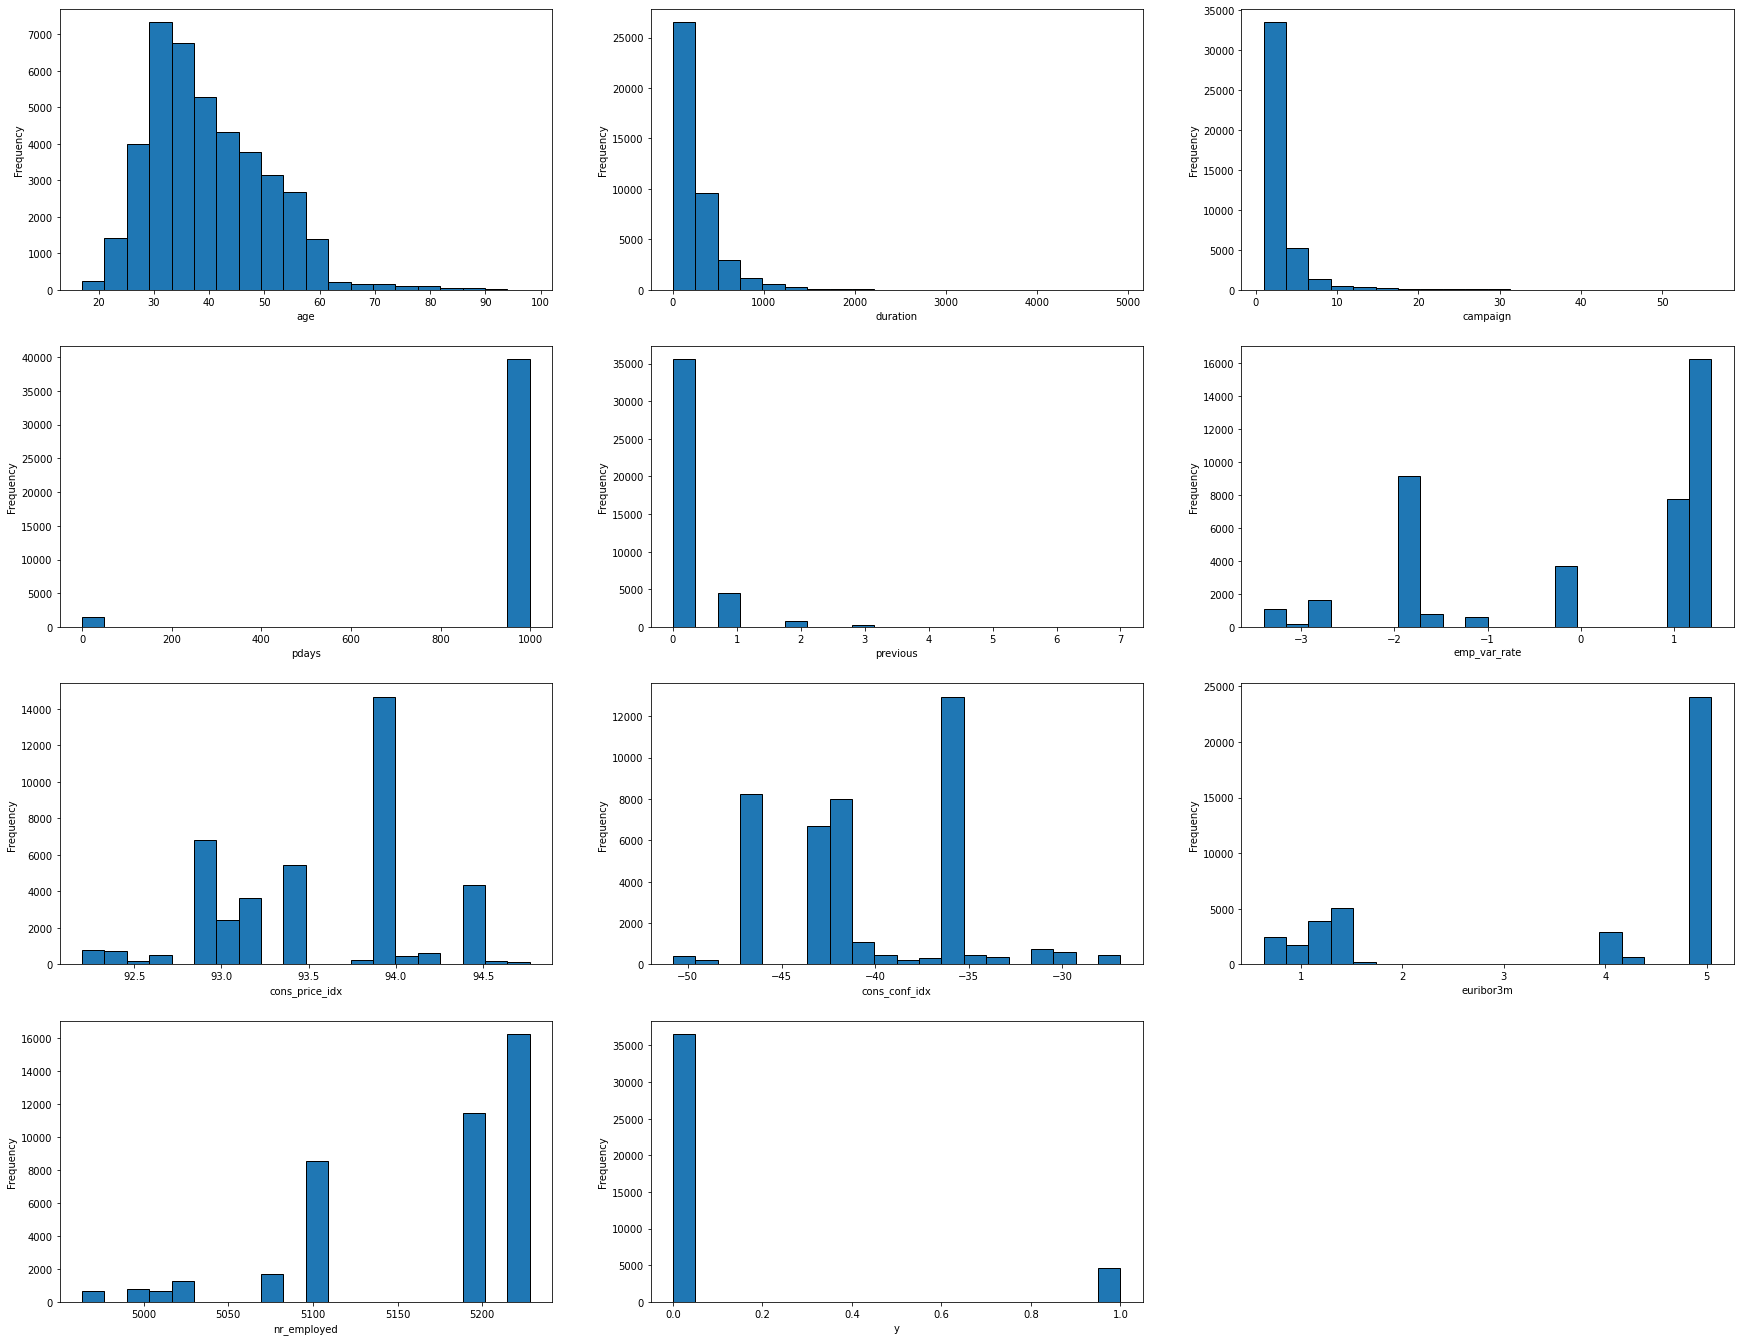

In [ ]:
plt.figure(figsize=(30,30))
cols = df.select_dtypes(exclude='object').columns
for f in range(len(cols)):
    plt.subplot( 5, 3, f + 1)
    column = cols[f]
    plt.xlabel(column,loc='center')
    plt.ylabel("Frequency")
    plt.hist(df[column], edgecolor='black', bins=20)

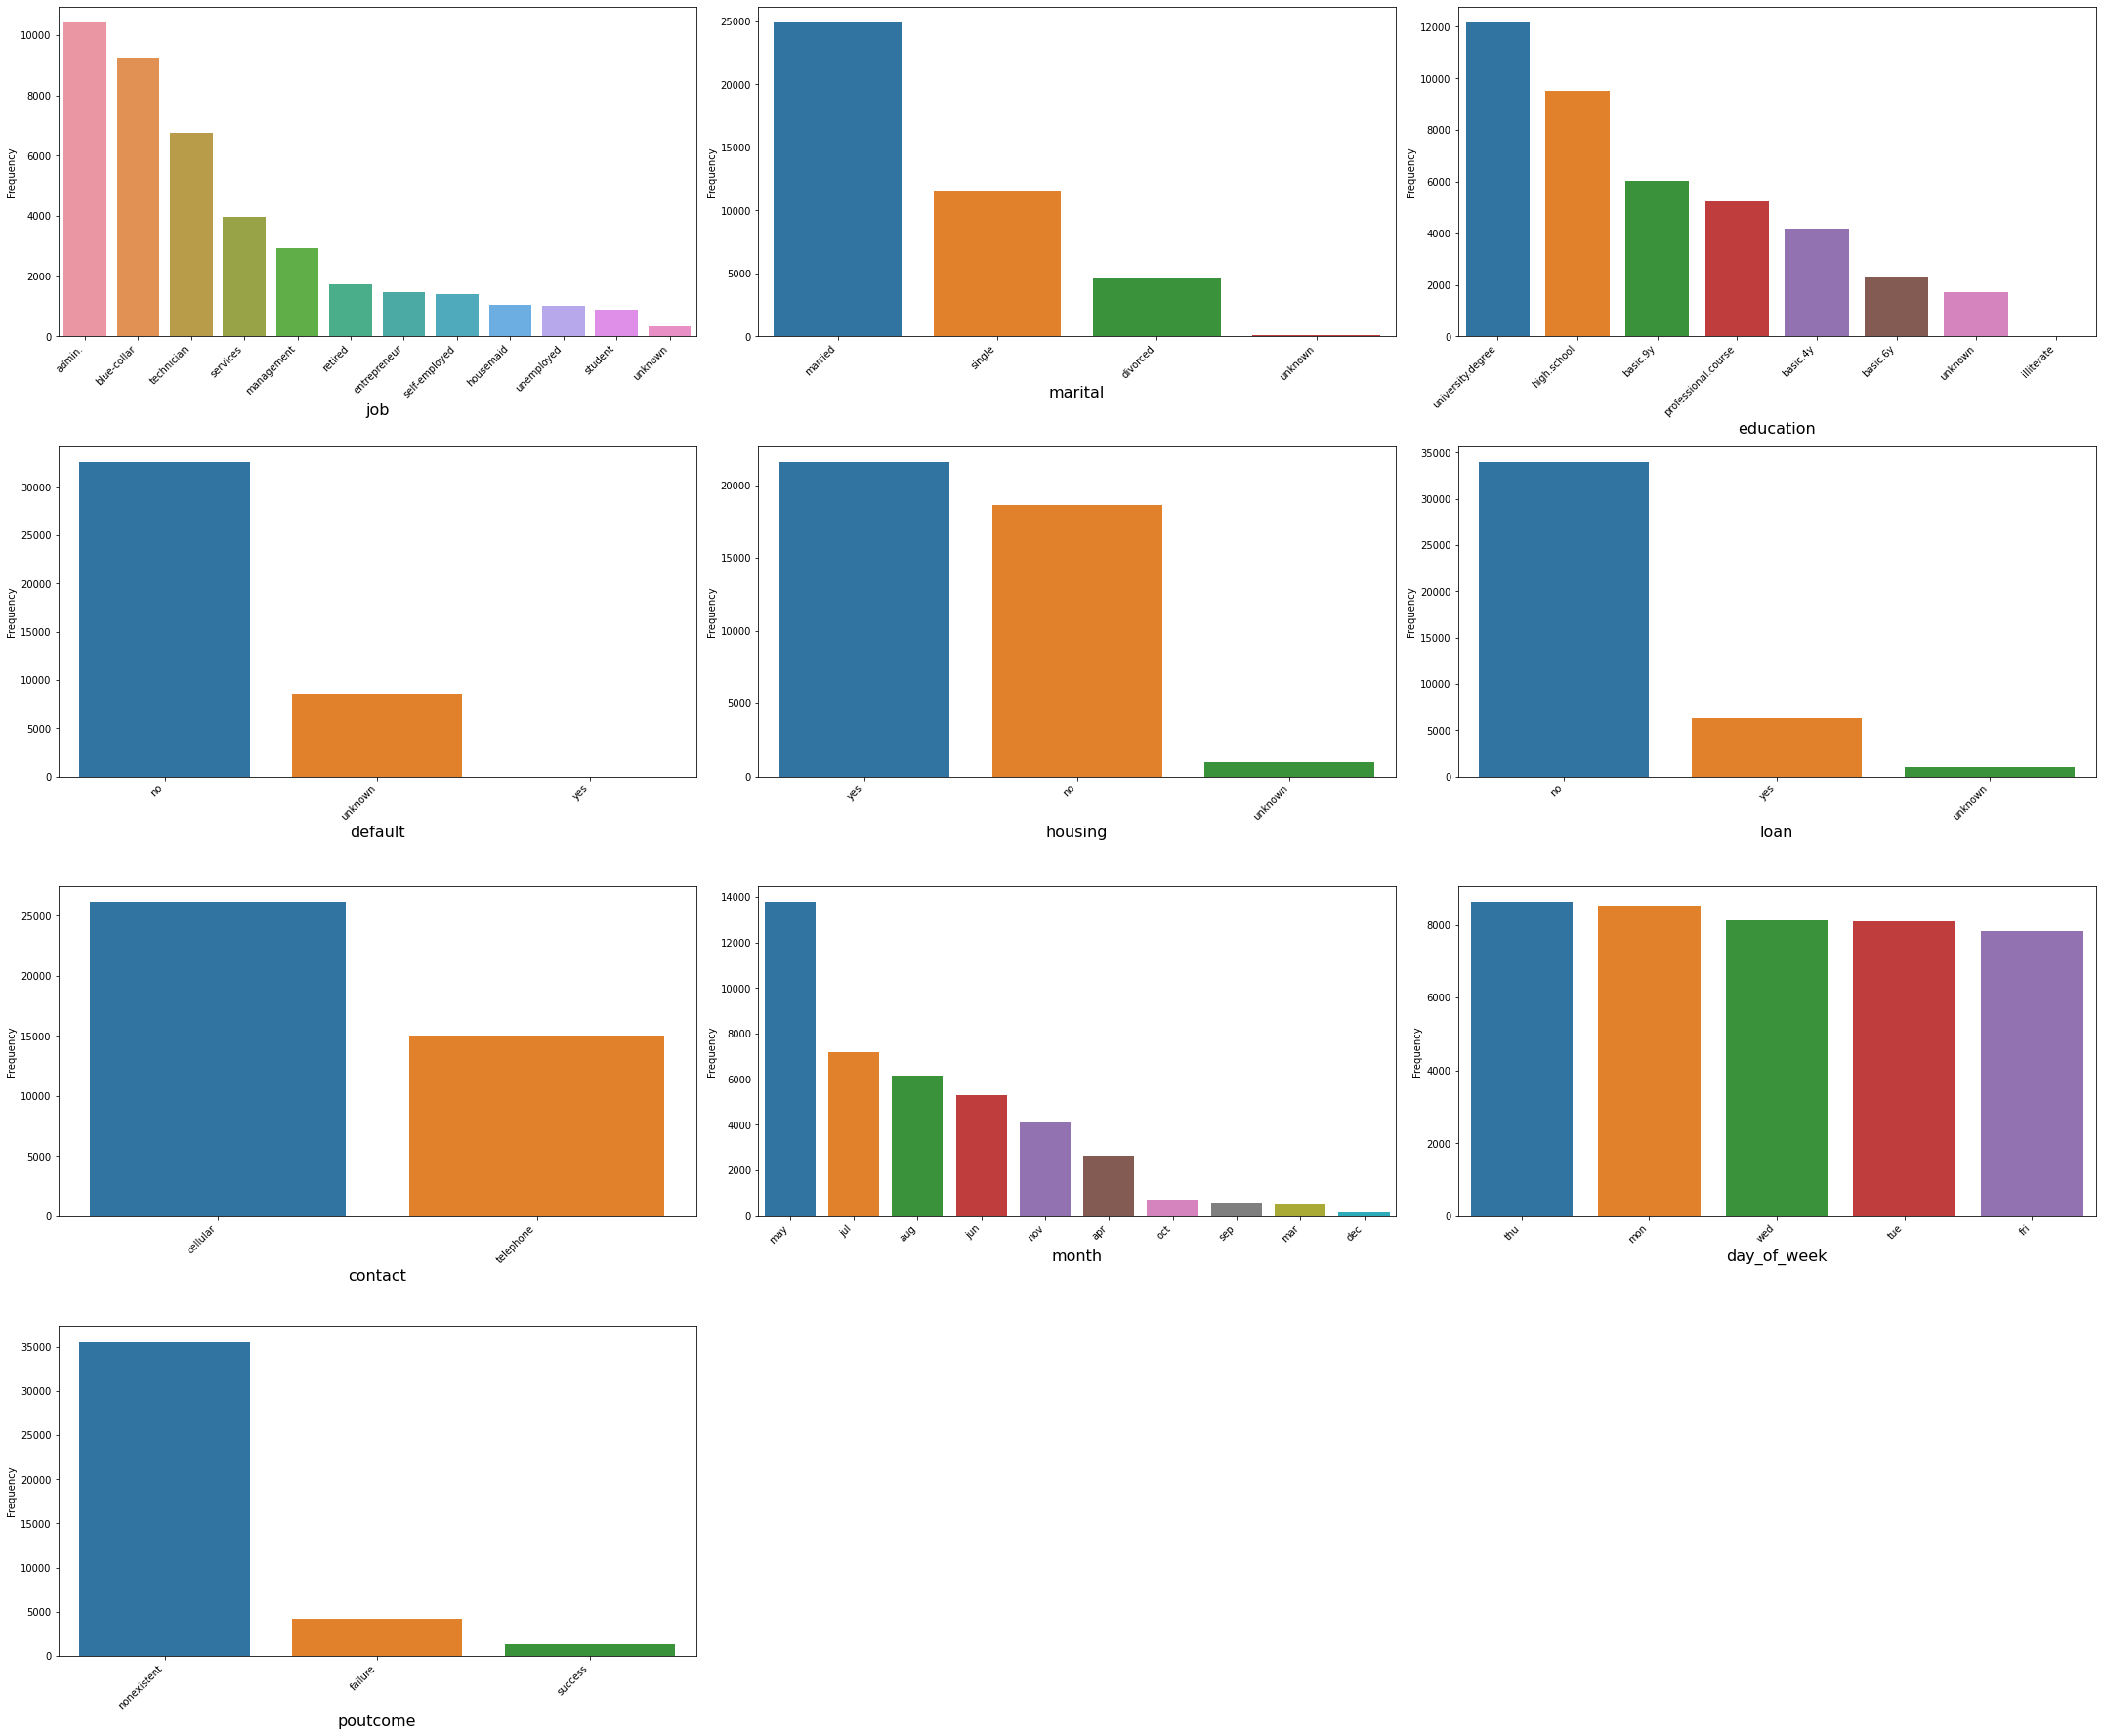

In [ ]:
fig = plt.figure(figsize=(30,30))
cols = df.select_dtypes(include='object').columns
for index , col in enumerate(cols):
    ax = plt.subplot( 5, 3, index + 1)
    plt.xlabel(col,loc='center', fontdict={'fontsize' : 16})
    plt.ylabel("Frequency")
    data = df[col].value_counts()
    sns.barplot(x = data.keys(), y = data.values)
    ax.set_xticklabels(labels=data.keys(), rotation=45, ha='right')
fig.tight_layout()

In [ ]:
df['y'].value_counts()/df['y'].shape[0]

0    0.887346
1    0.112654
Name: y, dtype: float64

As we can see, the target column(y) is imbalance. Class 1 comprises only around 10 percent of the data, and the rest is class 0. We should address this, since some models may perform poorly on imbalanced dataset.

# Preprocessing

## Missing Values

As we can see from barplots above, some attributes have value unknown. We assume that these unknown values in categorical columns are missing values. Since the proportion of missing values in job and marital is small, we drop rows containing them. In others, we decided to leave it as it is.

In [ ]:
indx = np.where((df['marital'] == 'unknown') | (df['job'] == 'unknown'))
df.drop(index = indx[0], inplace=True)
df['duration'] = df['duration'] // 60

We don't need to apply preprocessing to the target column, so we decide to split the dataframe into the target column and features.

In [ ]:
attrs = df.drop(columns=['y'])
y = df['y']

## Outlier

There are various ways to recognize outliers in data. Isolation Forest and Local Outlier Factor are some of the multivariate outlier detection techniques. Here we decided to use the IQR as univariate outlier detection since the z-score is used for normal distribution.

First, we visualize each numeric variable separately with a boxplot. The boxplot of columns 'pdays' and 'previous' is quite odd. The reason is that most of the clients were not previously contacted, which makes others outliers. We decided to handle these columns differently. For the rest of the columns, we replace outliers with the upper bound of that feature.

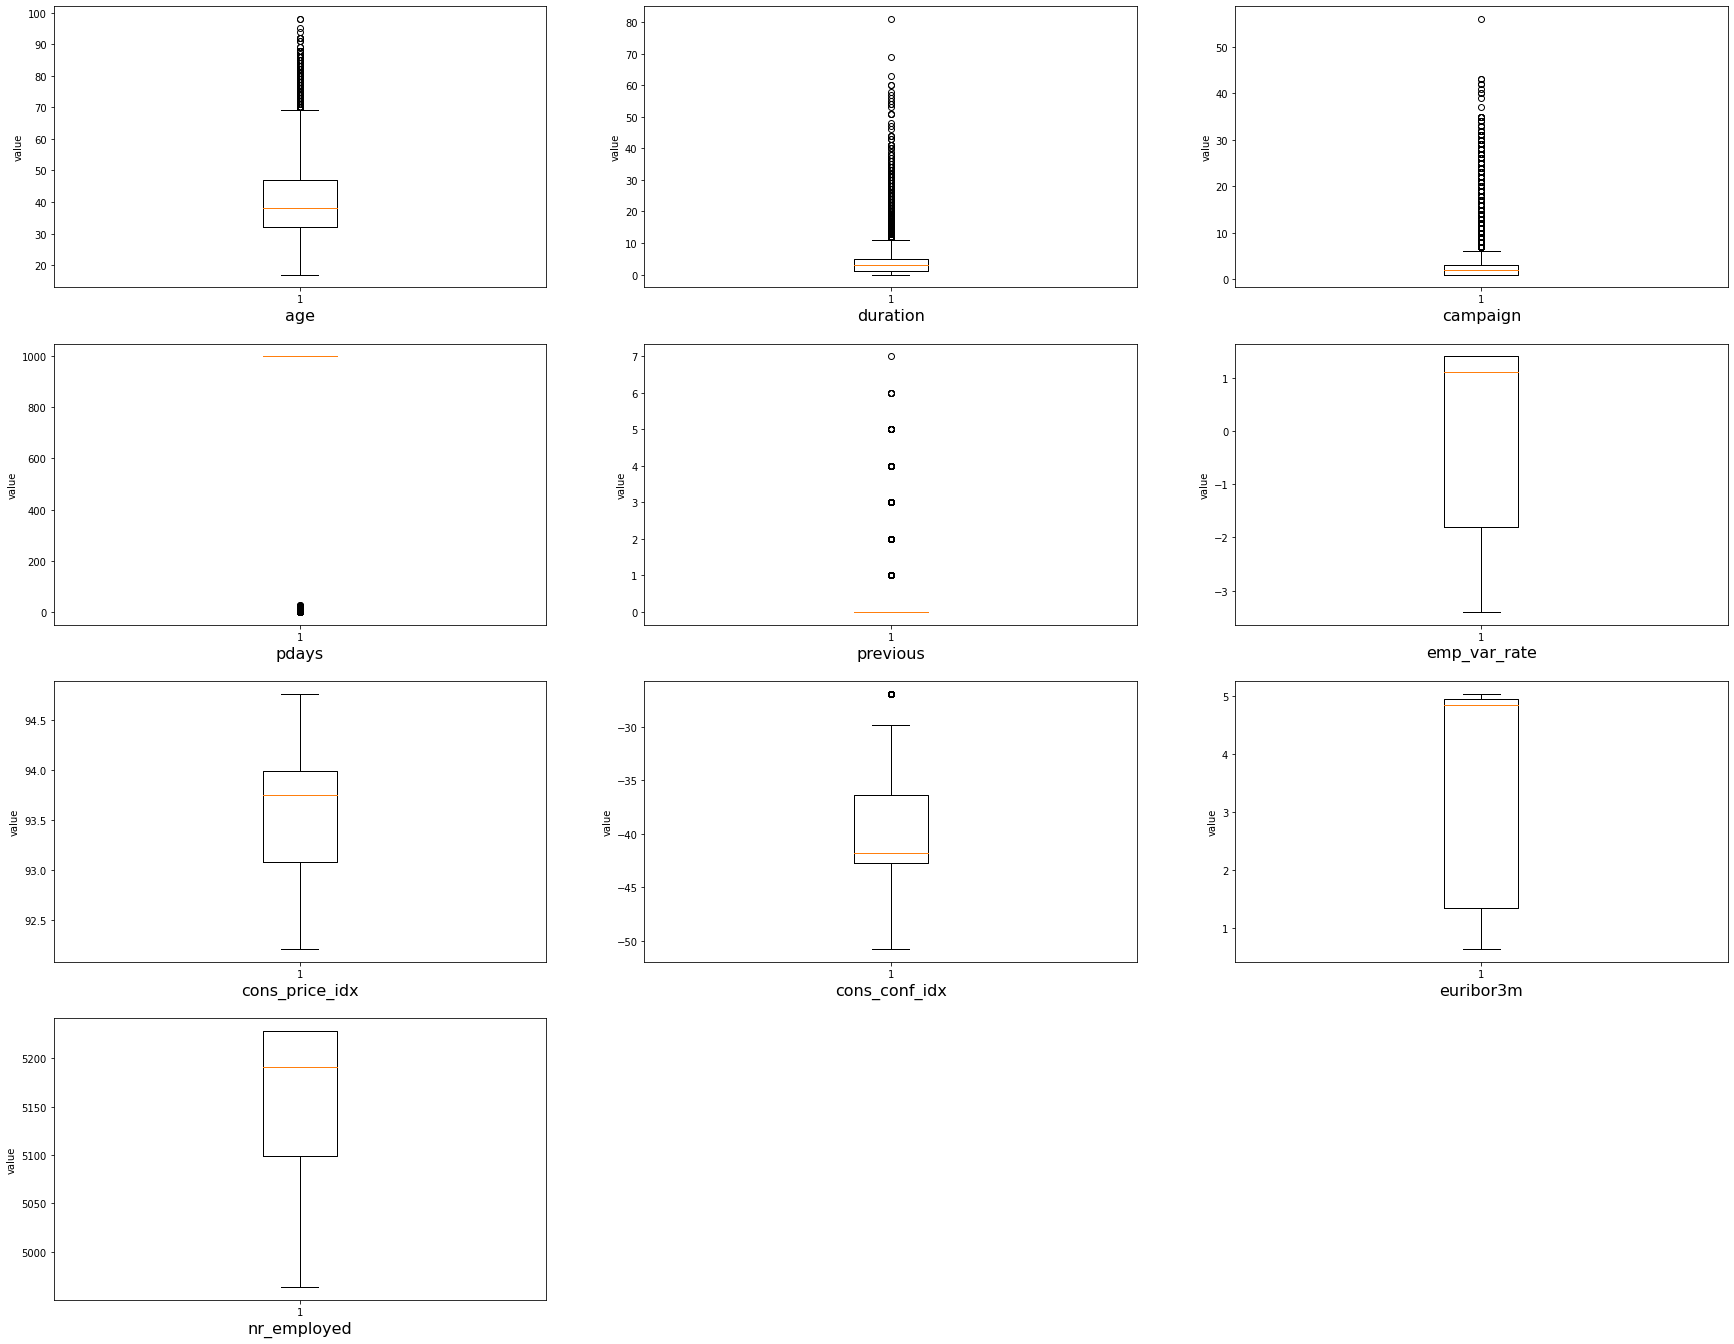

In [ ]:
plt.figure(figsize=(30,30))
cols = attrs.select_dtypes(exclude='object').columns
for f in range(len(cols)):
    plt.subplot( 5, 3, f + 1)
    column = cols[f]
    plt.xlabel(column,loc='center',fontdict={'fontsize' : 16})
    plt.ylabel("value")
    plt.boxplot(df[column])

In [ ]:
Q1 = attrs.quantile(0.25)
Q3 = attrs.quantile(0.75)

IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outlier_cols = ['age','duration', 'campaign','cons_conf_idx']
for c in outlier_cols:
    attrs.loc[(attrs[c] > upper_limit[c]),c] = upper_limit[c]
    attrs.loc[(attrs[c] < lower_limit[c]),c] = lower_limit[c]

## Encode Categorical

Categorical features can be encoded using OneHot encoding or ordinal encoding.
**Ordinal** encoder assigns an integer to each unique label.
**OneHot** encoder on the other hand, creates a binary column for each value in the categorical column.

First, let's look at categorical features. Other than education, which can be considered as an ordinal categorical feature, others are nominal features.
We don't use ordinal encoders for nominal features because two values closer to each other are considered to be more similar, and this is not the case for nominal features.

In [ ]:
enc_df = attrs.copy()
cat_df = enc_df.select_dtypes(include='object')
cat_col = cat_df.columns
cat_df.nunique()

job            11
marital         3
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [ ]:
enc = OneHotEncoder() # drop= if_binary
enc.fit(cat_df)
enc_arr = enc.transform(cat_df).toarray()
oneHot_cols = enc.get_feature_names_out()

enc_df.drop(columns = cat_col, inplace= True)
oneHot_df = pd.DataFrame(data = enc_arr, columns= oneHot_cols, index = df.index)
enc_df = pd.concat([enc_df,oneHot_df],axis=1)

In [ ]:
enc_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44.0,3,1,999,0,1.4,93.444,-36.10,4.963,5228.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,53.0,2,1,999,0,-0.1,93.200,-42.00,4.021,5195.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,28.0,5,3,6,2,-1.7,94.055,-39.80,0.729,4991.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,39.0,3,2,999,0,-1.8,93.075,-47.10,1.405,5099.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,55.0,2,1,3,1,-2.9,92.201,-31.40,0.869,5076.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59.0,3,1,999,0,1.4,94.465,-41.80,4.866,5228.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41184,31.0,3,2,999,0,1.1,93.994,-36.40,4.860,5191.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41185,42.0,1,3,999,0,1.1,93.994,-36.40,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
41186,48.0,3,2,999,0,-3.4,92.431,-26.95,0.742,5017.5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Feature Scaling

Many estimators are designed with the assumption that each feature has values close to zero and that all features vary on comparable scales. If a feature has a variance that is larger than others, it might dominate the objective function.

Two of the most common methods are min-max scaling and standard scaling.

**MinMax** scaling, also known as normalization, shifts and rescales values so that they end up ranging from 0 to 1 (or an arbitrary range).

**Standard** Scaling or standardization transforms the distribution by dividing the difference between each value and the mean by the standard deviation. This ensures that the distribution always has a mean of zero and a variance of one.

Both StandardScaler and MinMaxScaler are very sensitive to outliers. (Minmax is more sensitive to outliers.)

Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). Also, it assumes that the data follows a normal distribution.

Since we've previously dealt with outliers, we choose min-max scaling for the above reasons

In [ ]:
scaler = MinMaxScaler()
scaled_arr = scaler.fit_transform(enc_df)
scaled_df = pd.DataFrame(scaled_arr, columns=enc_df.columns , index= enc_df.index)
scaled_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.514286,0.272727,0.0,1.000000,0.000000,1.000000,0.484412,0.616352,0.981410,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.685714,0.181818,0.0,1.000000,0.000000,0.687500,0.389322,0.368973,0.767853,0.877883,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.209524,0.454545,0.4,0.006006,0.285714,0.354167,0.722525,0.461216,0.021537,0.105860,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.419048,0.272727,0.2,1.000000,0.000000,0.333333,0.340608,0.155136,0.174790,0.512287,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.723810,0.181818,0.0,0.003003,0.142857,0.104167,0.000000,0.813417,0.053276,0.425709,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.800000,0.272727,0.0,1.000000,0.000000,1.000000,0.882307,0.377358,0.959420,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41184,0.266667,0.272727,0.2,1.000000,0.000000,0.937500,0.698753,0.603774,0.958059,0.859735,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41185,0.476190,0.090909,0.4,1.000000,0.000000,0.937500,0.698753,0.603774,0.957379,0.859735,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
41186,0.590476,0.272727,0.2,1.000000,0.000000,0.000000,0.089634,1.000000,0.024484,0.203781,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Dimensionality Reduction

We have to remove features that are irrelevant with respect to the classification task or redundant.
Not handling it will make the model sensitive to noise and degrade the generalization of the model.

We have two approaches to select p features from the original feature set: **feature selection** and **feature engineering**.
In feature selection, we select p best features based on some measures. In feature engineering, we construct p features.

A feature is relevant or good if it is highly correlated with the class label. We use the chi-squared test for correlation between class labels and categorical features. We choose a significance level of (0.0005), which is the maximum probability of rejecting a null hypothesis when it's wrong. If the p-value is less than the significance level, we reject the null hypothesis and conclude that the two values are correlated.

In [ ]:
chi_square , p = chi2(enc_df[oneHot_cols],y)

Let's look at the chi2 and p values. As we can see in the left diagram, poutcom_sucess is highly correlated with class label, as we expected. We can also see some features that have no correlation with the class label in the right diagram, which we are going to remove.

[Text(0.5, 0, 'features'), Text(0, 0.5, 'p-value')]

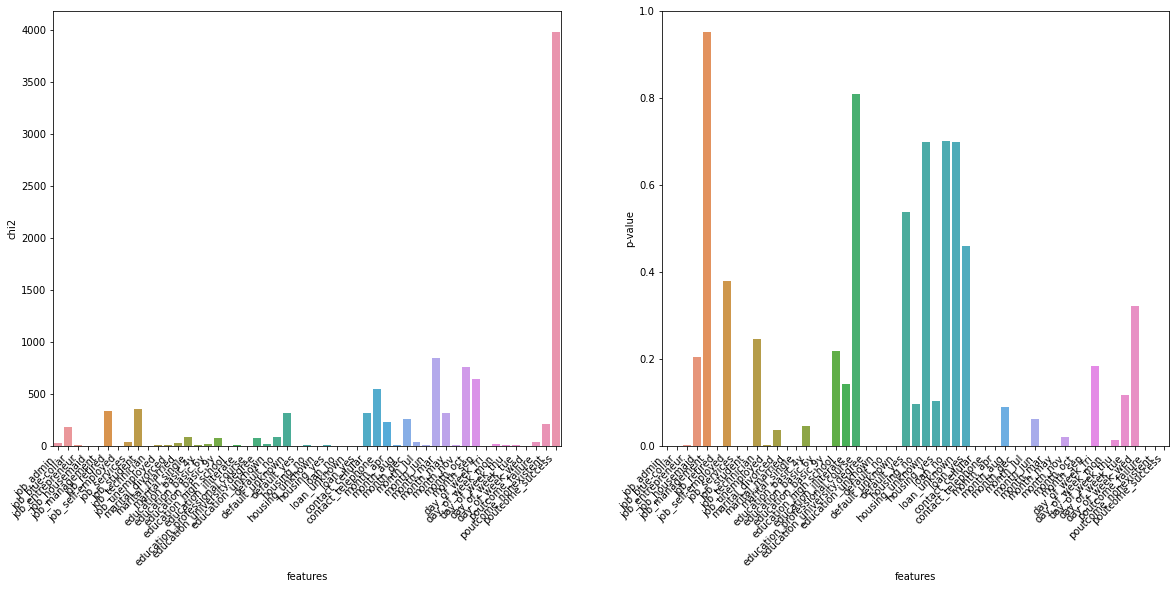

In [ ]:
fig, ax = plt.subplots(figsize = (20,8) , nrows= 1 , ncols= 2)
sns.barplot(x = oneHot_cols, y = chi_square, ax=ax[0])
ax[0].set_xticklabels(labels = oneHot_cols, rotation=45, ha='right')
ax[0].set(xlabel='features', ylabel='chi2')

sns.barplot(x = oneHot_cols, y = p, ax=ax[1])
ax[1].set_xticklabels(labels = oneHot_cols, rotation=45, ha='right')
ax[1].set(xlabel='features', ylabel='p-value')

In [ ]:
cat_cols_drop = oneHot_cols[np.where(p > 0.0005)]
cat_cols_drop

array(['job_entrepreneur', 'job_housemaid', 'job_management',
       'job_self-employed', 'job_technician', 'job_unemployed',
       'marital_divorced', 'education_basic.4y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'default_yes', 'housing_no', 'housing_unknown', 'housing_yes',
       'loan_no', 'loan_unknown', 'loan_yes', 'month_aug', 'month_jun',
       'month_nov', 'day_of_week_fri', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed'], dtype=object)

We use Pearson correlation to find redundant features. As we can see, emp_var_rate and euribor3m are highly correlated. We decided to remove emp_var_rate because euribor3m is more correlated to class feature.




<Axes: >

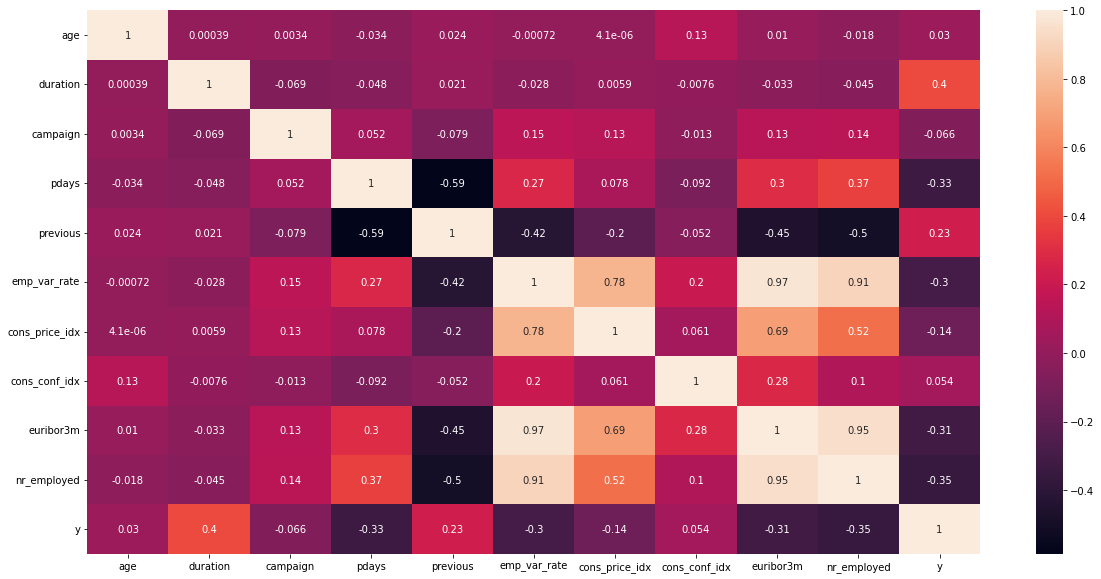

In [ ]:
plt.figure(figsize=(20,10))
corr = df.corr()
sns.heatmap(corr,annot=True)

We delete age column since it shows no correlation with class label.

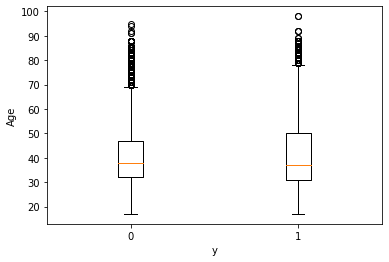

In [ ]:
plt.boxplot([df["age"][df["y"] == 0], df["age"][df["y"] == 1]], labels=["0", "1"])
plt.ylabel("Age")
plt.xlabel("y")
plt.show()

'pdays' and 'previous' are negatively correlated.

'pdays' is the number of days that passed after the client was last contacted from a previous campaign. 999 value means the client was not previously contacted.

'previous' is the number of contacts performed before this campaign and for this client. Finally, poutcome is the outcome of the previous campaign.

Since values 999 in pdays, 0 in previous, and nonexistent in poutcome happen together and comprise more than 85 percent of the data, we decided to keep only one of them and remove others since they're redundant. (pdays and previous)

In [ ]:
df[['poutcome','previous']].value_counts()/df.shape[0]

poutcome     previous
nonexistent  0           0.863437
failure      1           0.089980
success      1           0.020889
failure      2           0.010543
success      2           0.007600
             3           0.003114
failure      3           0.002133
success      4           0.000981
failure      4           0.000736
success      5           0.000368
             6           0.000098
failure      5           0.000074
             6           0.000025
success      7           0.000025
dtype: float64

In [ ]:
num_cols_drop = ['emp_var_rate','age','pdays','previous']
scaled_df.drop(columns = num_cols_drop, inplace= True)
scaled_df.drop(columns= cat_cols_drop, inplace=True)

In [ ]:
scaled_df

,duration,campaign,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_admin.,job_blue-collar,job_retired,job_services,...,month_dec,month_jul,month_mar,month_may,month_oct,month_sep,day_of_week_mon,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.272727,0.0,0.484412,0.616352,0.981410,1.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.181818,0.0,0.389322,0.368973,0.767853,0.877883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.454545,0.4,0.722525,0.461216,0.021537,0.105860,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.272727,0.2,0.340608,0.155136,0.174790,0.512287,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.181818,0.0,0.000000,0.813417,0.053276,0.425709,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.272727,0.0,0.882307,0.377358,0.959420,1.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41184,0.272727,0.2,0.698753,0.603774,0.958059,0.859735,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
41185,0.090909,0.4,0.698753,0.603774,0.957379,0.859735,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
41186,0.272727,0.2,0.089634,1.000000,0.024484,0.203781,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We decided not to use PCA, because it assumes that variables are continuous and have a variance structure. Most of our features are categorical, which are discrete and do not have a meaningful variance or distance measure.

# Phase 2

First, we need to split data into 3 parts : train, validation, and test set.
We need to stratify data to preserve the distribution of the target variable in each part. This makes the evaluation more reliable and less sensitive to the random splitting of the data.

In [ ]:
X = scaled_df
y =  y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

We're going to use Macro-F1, Micro-F1, and accuracy to evaluate our models.

**Micro-f1** and **Macro-f1** are two ways of calculating the f1-score for multi-class or multi-label classification problems.

**Micro-f1** calculates the metrics globally by counting the total true positives, false negatives and false positives across all classes. It gives equal weight to each prediction, regardless of the class. It is equivalent to accuracy for binary classification.

micro-F1 ​= 2TP/ 2TP+FN+FP​

**Macro-f1** Is the average of the F1 scores for each class or label, without weighting. It gives equal weight to each class, regardless of its size or frequency. It does not take label imbalance into account.

# SVM

SVM tries to find the linear optimal hyperplane that maximizes the margin between the classes. For linearly inseparable data, SVM transfer data into a higher dimensional space (by adding new features to the data) where it can be separated by a hyperplane.
SVM achieve this by applying different kernel functions on data. The kernel is a way of computing the dot product of two vectors x and y in some (very high dimensional) feature space.

## Parameters

The parameter **C**, common to all SVM kernels, is a regularization parameter which determines how much penalty is given to misclassifications.

- A large C means a hard margin SVM, which does not tolerate errors and tries to fit the data as closely as possible.(smaller margin,fewer margin violations)
- A small C means a soft margin SVM, which allows some errors and tries to find a simpler boundary that works well for most of the data.(larger margin)

a smaller C will generalize better, while a higher value is prone to overfitting.

## Linear

We should set class_weight='balanced' if the data is unbalanced (e.g. many positive and few negative). It uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.

In [ ]:
C = [0.5,1,2,10,50]

linear_res = pd.DataFrame(columns= ['set','C','accuracy','macro_f1','micro_f1'])

for c in C:
    linear_svc = svm.SVC(kernel='linear', C = c,class_weight='balanced')
    linear_svc.fit(X_train,y_train)
    y_val_pred = linear_svc.predict(X_val)
    val_report = classification_report(y_true=y_val, y_pred=y_val_pred, output_dict=True)
    val_micro = f1_score(y_true=y_val, y_pred=y_val_pred,average='micro')
    linear_res.loc[len(linear_res)] = ['val',c,val_report['accuracy'],val_report['macro avg']['f1-score'], val_micro]

    y_train_pred = linear_svc.predict(X_train)
    train_report = classification_report(y_true=y_train, y_pred=y_train_pred, output_dict=True)
    train_micro = f1_score(y_true=y_train, y_pred=y_train_pred,average='micro')
    linear_res.loc[len(linear_res)] = ['train',c,train_report['accuracy'],train_report['macro avg']['f1-score'], train_micro]

In [ ]:
linear_res

,set,C,accuracy,macro_f1,micro_f1
0,val,0.5,0.846286,0.739722,0.846286
1,train,0.5,0.844183,0.736443,0.844183
2,val,1.0,0.846776,0.740276,0.846776
3,train,1.0,0.844551,0.736902,0.844551
4,val,2.0,0.846899,0.740414,0.846899
5,train,2.0,0.844592,0.736901,0.844592
6,val,10.0,0.846776,0.740276,0.846776
7,train,10.0,0.844632,0.736994,0.844632
8,val,50.0,0.846408,0.739860,0.846408
9,train,50.0,0.844510,0.736902,0.844510


The accuracy and micro_f1 are the same and higher than macro_f1. This indicates that the model has performed better in predicting the majority class. Since we are dealing with class imbalance, both of these measures are not good indicators of the model's performance.

## Polynomial kernel:
                                            K(x,y)=(γ<x.y> + coef0)^ degree

### Hyperparameter
                                        
**degree**: The degree of the polynomial kernel function that determines the complexity and flexibility of the hyperplane.

**coef0**: It controls the influence of the constant term in the polynomial and how much the model is influenced by high-degree polynomials versus low-degree polynomials. A larger c0​ means a higher degree of non-linearity, while a smaller c0​ means a lower degree of non-linearity.


In [ ]:
C = [0.5,1,2]
degree= [3,4,5]
coef0 = [0,1]

poly_res = pd.DataFrame(columns= ['set','C','degree','coef0','accuracy','macro_f1','micro_f1'])

for c in C:
    for d in degree:
        for r in coef0:
            p_svc = svm.SVC(kernel='poly',degree= d,C = c,coef0=r,class_weight='balanced')
            p_svc.fit(X_train,y_train)
            y_val_pred = p_svc.predict(X_val)
            report = classification_report(y_true=y_val, y_pred=y_val_pred, output_dict=True)
            micro = f1_score(y_true=y_val, y_pred=y_val_pred,average='micro')
            poly_res.loc[len(poly_res)] = ['val',c,d,r,report['accuracy'],
                                        report['macro avg']['f1-score'], micro]

            y_train_pred = p_svc.predict(X_train)
            train_report = classification_report(y_true=y_train, y_pred=y_train_pred, output_dict=True)
            train_micro = f1_score(y_true=y_train, y_pred=y_train_pred, average='micro')
            poly_res.loc[len(poly_res)] = ['train',c,d,r,train_report['accuracy'],
                                        train_report['macro avg']['f1-score'], train_micro]

In [ ]:
poly_res

,set,C,degree,coef0,accuracy,macro_f1,micro_f1
0,val,0.5,3,0,0.844447,0.740246,0.844447
1,train,0.5,3,0,0.851048,0.748632,0.851048
2,val,0.5,3,1,0.843957,0.739563,0.843957
3,train,0.5,3,1,0.851661,0.749600,0.851661
4,val,0.5,4,0,0.845428,0.738754,0.845428
5,train,0.5,4,0,0.858772,0.758570,0.858772
6,val,0.5,4,1,0.850086,0.741668,0.850086
7,train,0.5,4,1,0.866618,0.768889,0.866618
8,val,0.5,5,0,0.849841,0.740106,0.849841
9,train,0.5,5,0,0.869192,0.771897,0.869192


When we set degree = 5 and coef0 = 1, the model performs better on the train set, while its performance on the validation set remains the same. It appears that since the model is more complex, it is overfitted on the train set.

When using a polynomial kernel, the parameters with the best performance are C = 1.0, degree = 4, and coef0 = 0 (row 16).

## RBF

The RBF kernel function is defined as:

                                            K(x,y)=exp(−γ∥x−y∥^ 2)
where x and y are two data points, ∥x−y∥ is their Euclidean distance, and γ > 0 defines how much influence a single training example has.

**RBF kernel** : The RBF kernel can be seen as an infinite sum of polynomial kernels of different degrees, which makes it more powerful and flexible than the polynomial kernel. It is a type of kernel that uses the radial basis function as the similarity measure. It is also known as the Gaussian kernel, because it has the form of a Gaussian distribution. The RBF kernel can handle non-linearly separable data very well, because it can create complex boundaries around the data.

**gamma**: a positive parameter that controls the width of the Gaussian function. it can also be prone to overfitting if the gamma parameter is too large.


In [ ]:
C = [1,1.5,3]
gamma = [0.01, 0.1, 1]
rbf_res = pd.DataFrame(columns= ['set','C', 'gamma' , 'accuracy','macro_f1','micro_f1'])

for c in C:
    for g in gamma:
        svc = svm.SVC(kernel='rbf', gamma=g, C = c, class_weight='balanced')
        svc.fit(X_train,y_train)
        y_val_pred = svc.predict(X_val)
        report = classification_report(y_true=y_val, y_pred=y_val_pred, output_dict=True)
        micro = f1_score(y_true=y_val, y_pred=y_val_pred,average='micro')
        rbf_res.loc[len(rbf_res)] = ['val',c,g,report['accuracy'],
                                      report['macro avg']['f1-score'],micro]

        y_train_pred = svc.predict(X_train)
        train_report = classification_report(y_true=y_train, y_pred=y_train_pred, output_dict=True)
        train_micro = f1_score(y_true=y_train, y_pred=y_train_pred, average='micro')
        rbf_res.loc[len(rbf_res)] = ['train',c,g,train_report['accuracy'],
                                    train_report['macro avg']['f1-score'], train_micro]

In [ ]:
rbf_res

,set,C,gamma,accuracy,macro_f1,micro_f1
0,val,1.0,0.01,0.841873,0.736016,0.841873
1,train,1.0,0.01,0.840137,0.733190,0.840137
2,val,1.0,0.10,0.842731,0.739535,0.842731
3,train,1.0,0.10,0.846226,0.742797,0.846226
4,val,1.0,1.00,0.857195,0.737004,0.857195
5,train,1.0,1.00,0.896939,0.808991,0.896939
6,val,1.5,0.01,0.844815,0.738892,0.844815
7,train,1.5,0.01,0.842426,0.735545,0.842426
8,val,1.5,0.10,0.842118,0.738453,0.842118
9,train,1.5,0.10,0.847329,0.744131,0.847329


When we set gamma = 1, the macro-f1 measure on the train set became more than 80% (around 10% increase), while on the validation set it remained at 73%. It seems that by setting gamma = 1, the model is overfitting.
Here we pick C = 1 and gamma = 0.1

We achieve similar performance on the validation set while applying the linear, polynomial, and rbf kernels. We choose the linear kernel since it is less complex, computationally efficient and generalizes better.

Finally, we evaluate model with best parameters on test data.

In [ ]:
linear_clf = svm.SVC(kernel='linear', C = 2,class_weight='balanced')
linear_clf.fit(X_train,y_train)
y_test_pred = linear_clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7239
           1       0.41      0.90      0.56       919

    accuracy                           0.84      8158
   macro avg       0.70      0.87      0.73      8158
weighted avg       0.92      0.84      0.87      8158



# MLP

A neural network is a set of connected input-output units in which each connection has a weight associated with it.
During the learning phase, the network learns by adjusting the weights in order to predict the correct target values of the input tuples.

A multilayer feed-forward neural network consists of an input layer, one or more hidden layers, and an output layer.
The input layer consists of a set of neurons representing the input features. Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation followed by a non-linear activation function.
                y = f(wx + b)

Activation functions introduce non-linearity into the network, allowing it to learn complex patterns and perform tasks that linear models cannot. The **tanh** activation function is a variant of the sigmoid. It maps the set of real values from (–∞, +∞) to the range [­1, +1].

The output layer receives the values from the last hidden layer and transforms them into output values.

## Hyperparameter

- `The number and size of hidden layer`: Affect the complexity and the capacity of the MLP to learn non-linear patterns from the data. One hidden layer is sufficient for the large majority of problems. The optimal size of the hidden layer is usually between the size of the input and size of the output layers. The more complex NN gets by increasing the number of hidden layers and neurons in each layer, the more prone it is to overfitting and having high variance.

- `The activation function`: what kind of non-linear function is applied to the output of each neuron in the hidden layers. The activation function affects the range and the shape of the output, as well as the gradient flow during backpropagation.

- `The learning rate`: How much the weights and biases are changed in each iteration of training. The learning rate affects the convergence speed and stability, as well as the risk of overshooting or getting stuck in local minima.

In [ ]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, weight_initializer):

        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        weight_initializer(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        weight_initializer(self.fc2.weight)


    def forward(self, x_in, apply_softmax = False):

        intermediate = torch.tanh(self.fc1(x_in))
        output = self.fc2(intermediate)

        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output

In [ ]:
class BankDataset(Dataset):
    def __init__(self, X, y):
        assert(X.index.equals(y.index))
        self.X = X
        self.y = y
        self._target_size = len(self.X)

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        x_row = self.X.iloc[index].to_numpy()
        y_row = np.array([self.y.iloc[index]])
        return {'x_data': x_row, 'y_target': y_row}

To deal with imbalanced data, we used WeightedRandomSampler. It allows us to sample data from a dataset with a specified probability for each sample. We assign higher weights to the underrepresented samples(class 1). We only use this on train dataset.

In [ ]:
def create_weights(target):
    class_count = target.value_counts()
    class_weight = 1./class_count
    weights = [class_weight[t] for t in target]
    return weights

def generate_batches(dataset, batch_size, shuffle=True,
    drop_last=True, device="cpu", use_sampler = False):

    target_list = []
    for data_dict in dataset:
        target_list.append(data_dict['y_target'][0])

    target_list = pd.Series(target_list)

    weights = create_weights(target_list)
    sampler = WeightedRandomSampler(weights,len(weights),replacement=True)

    if use_sampler :
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
        drop_last=drop_last,sampler=sampler)
    else:
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [ ]:
train_dataset = BankDataset(X_train,y_train)
val_dataset = BankDataset(X_val,y_val)
test_dataset = BankDataset(X_test,y_test)

Most appropriate loss function for binary classification is binary cross­entropy loss.
BCEWithLogitsLoss combines a `Sigmoid` layer and the `BCELoss` in one single class. This version is more numerically stable than using a plain `Sigmoid` followed by a `BCELoss`.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def test(args, test_dataset,classifier):
    y_pred_list = []
    y_true_list = []
    test_state = {'accuracy': 0, 'loss': -1 , 'macro_f1': -1, 'micro_f1': -1}
    batch_generator = generate_batches(test_dataset,
                                       batch_size=args.batch_size,device=args.device,use_sampler=False)
    running_loss = running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):

        y_pred = classifier(batch_dict['x_data'].float())
        loss = criterion(y_pred, batch_dict['y_target'].float())
        y_pred_tag = torch.round(torch.sigmoid(y_pred))

        loss_batch = loss.item()
        running_loss += loss_batch

        acc_batch = (batch_dict['y_target'] ==  y_pred_tag).float().sum().item()
        running_acc += acc_batch

        y_pred_list.append(y_pred_tag)
        y_true_list.append(batch_dict['y_target'])


    epoch_y_pred = torch.cat(y_pred_list).detach()
    epoch_y_true = torch.cat(y_true_list).detach()

    test_state['accuracy'] = 100 * running_acc / len(test_dataset)
    test_state['loss'] = running_loss/len(test_dataset)
    test_state['macro_f1'] = f1_score(epoch_y_true,epoch_y_pred,average='macro')
    test_state['micro_f1'] = f1_score(epoch_y_true,epoch_y_pred,average='micro')
    test_state['weighted_f1'] = f1_score(epoch_y_true,epoch_y_pred,average='weighted')

    return test_state , epoch_y_pred, epoch_y_true

In [ ]:
def train(args,train_dataset,val_dataset,classifier,optimizer):

    train_state = {'train_loss': [], 'train_acc': [],
                   'val_loss': [], 'val_acc': []}

    for epoch_index in range(args.num_epochs):
        batch_generator = generate_batches(train_dataset, batch_size= args.batch_size,
                                            device=args.device,use_sampler=args.use_sampler)
        running_loss = running_acc  = 0.0
        classifier.train()
        for batch_index, batch_dict in enumerate(batch_generator):

            optimizer.zero_grad()
            y_pred = classifier(batch_dict['x_data'].float())
            loss = criterion(y_pred, batch_dict['y_target'].float())
            loss_batch = loss.item()
            running_loss += loss_batch

            loss.backward()
            optimizer.step()

            y_pred_tag = torch.round(torch.sigmoid(y_pred))
            acc_batch = (batch_dict['y_target'] ==  y_pred_tag).float().sum().item()
            running_acc += acc_batch

        epoc_acc = 100 * running_acc / len(train_dataset)
        epoc_loss = running_loss/len(train_dataset)
        train_state['train_loss'].append(epoc_loss)
        train_state['train_acc'].append(epoc_acc)

        if epoch_index % 5 == 0 :
            print(f"Epoch {epoch_index + 1} - accuracy: {epoc_acc: .3f} - loss:{epoc_loss: .5f}")

    return train_state

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_train.shape[1]
output_dim = 1

args = Namespace(batch_size = 64,
num_epochs = 20,
device = device,
use_sampler = True)

## Different Initiations

MLPs with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.

We've used torch.nn.init.xavier_uniform_, torch.nn.init.normal_, or torch.nn.init.uniform_, and applied it to each layer’s weight.

In [ ]:
dim = [8,16,32,64]
init_weights = [torch.nn.init.uniform_ , torch.nn.init.xavier_uniform_ ,torch.nn.init.normal_ ]

results = []
for d in dim:
    for initializer in init_weights :
        print(f"Hidden layer: {d} - initializer: {initializer.__name__}")
        classifier = MultilayerPerceptron(input_dim , d , output_dim, initializer)
        classifier = classifier.to(device)
        optimizer = torch.optim.Adam(classifier.parameters())
        train_hist = train(args,train_dataset,val_dataset,classifier,optimizer)
        state, val_pred, val_label = test(args,val_dataset,classifier)
        print(classification_report(val_label,val_pred))
        state['Hidden'] = d
        state['initializer'] = initializer.__name__
        results.append(state)


Hidden layer: 8 - initializer: uniform_
Epoch 1 - accuracy:  55.229 - loss: 0.02250
Epoch 6 - accuracy:  87.475 - loss: 0.00493
Epoch 11 - accuracy:  87.990 - loss: 0.00464
Epoch 16 - accuracy:  88.157 - loss: 0.00458
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7213
           1       0.42      0.94      0.58       915

    accuracy                           0.85      8128
   macro avg       0.71      0.89      0.75      8128
weighted avg       0.93      0.85      0.87      8128

Hidden layer: 8 - initializer: xavier_uniform_
Epoch 1 - accuracy:  74.443 - loss: 0.00838
Epoch 6 - accuracy:  87.634 - loss: 0.00481
Epoch 11 - accuracy:  87.536 - loss: 0.00474
Epoch 16 - accuracy:  88.300 - loss: 0.00458
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7211
           1       0.42      0.94      0.58       917

    accuracy                           0.85      8128
   macro avg

Here we can see the performance of the model on the validation set with different initiations and hidden layer sizes. The maximum improvement in the performance of the model by increasing the hidden layer size is around 2%.

In [ ]:
res_df = pd.DataFrame(results)
res_df

,accuracy,loss,macro_f1,micro_f1,weighted_f1,Hidden,initializer
0,84.628585,0.005049,0.745742,0.849409,0.871541,8,uniform_
1,84.358911,0.005131,0.742941,0.846703,0.869408,8,xavier_uniform_
2,83.525374,0.005448,0.732676,0.838337,0.862942,8,normal_
3,84.689875,0.004957,0.746444,0.850025,0.871937,16,uniform_
4,85.118902,0.004856,0.749913,0.854331,0.875127,16,xavier_uniform_
5,83.807306,0.005461,0.736614,0.841166,0.865197,16,normal_
6,84.591812,0.005053,0.744780,0.849040,0.871217,32,uniform_
7,84.947291,0.004978,0.749545,0.852608,0.873877,32,xavier_uniform_
8,85.057612,0.005259,0.748514,0.853716,0.874548,32,normal_
9,84.702133,0.005103,0.746180,0.850148,0.872052,64,uniform_


To choose the best model from possible hyperparameters, we choose a model that has higher average performance and minimum variance upon different weight initiations. Although the model's performance is slightly better when the hidden layer is 64, it has the lowest variance when the hidden layer is 32. Hence, we chose a simpler model with layer_size = 32.

In [ ]:
res_df.groupby('Hidden').mean()

,accuracy,loss,macro_f1,micro_f1,weighted_f1
Hidden,,,,,
8,84.170957,0.005209,0.740453,0.844816,0.867964
16,84.538694,0.005091,0.744324,0.848507,0.870753
32,84.865572,0.005097,0.747613,0.851788,0.873214
64,85.568358,0.004907,0.753295,0.858842,0.878286


In [ ]:
res_df.groupby('Hidden').std()

,accuracy,loss,macro_f1,micro_f1,weighted_f1
Hidden,,,,,
8,0.575121,0.000211,0.006879,0.005772,0.004478
16,0.668740,0.000324,0.006899,0.006712,0.005070
32,0.243415,0.000145,0.002507,0.002443,0.001762
64,0.762195,0.000321,0.006163,0.007650,0.005448


# CBA

CBA uses association rule mining techniques to build classifiers.
It consists of two parts, a rule generator (called **CBA-RG**), and a classifier builder (called **CBA-CB**).

CBA uses an approach similar to Apriori to find frequent(satisfying min_sup) itemset. The set of rules satisfying a min_confidence and min_sup are then generated. If a set of rules have the same antecedent, the rule with the highest confidence is selected to represent the set. We are only looking for Class Association Rule(CAR), which has a class label as the consequent and a set of items or attributes as its antecedent.

The confidence of the CAR is equivalent to accuracy.

**M1** is a naive CBA-CB, which prunes the rules by removing those that are covered by a higher ranked rule with the same consequent.
It works as follows:

First, all rules are sorted to ensure that rules with high confidence and support are chosen first.
Then for each rule, it checks the remaining instances. If the rule matches any instance (satisfies rule’s antecedent
and the instance’s class matches the consequent) the rule will append at the end of the decision list and the instance will be removed from the dataset.

When **classifying** a new tuple, the first rule satisfying the tuple is used to classify it.
The **default** rule is used for any new tuple that is not satisfied by any other rule in the classifier. It has a default class and the lowest precedence in decision list.

In [ ]:
cba_df = df.copy()
cba_df.drop(columns= num_cols_drop, inplace=True)
cba_df

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,3,1,nonexistent,93.444,-36.1,4.963,5228.1,0
1,technician,married,unknown,no,no,no,cellular,nov,fri,2,1,nonexistent,93.200,-42.0,4.021,5195.8,0
2,management,single,university.degree,no,yes,no,cellular,jun,thu,5,3,success,94.055,-39.8,0.729,4991.6,1
3,services,married,high.school,no,no,no,cellular,apr,fri,3,2,nonexistent,93.075,-47.1,1.405,5099.1,0
4,retired,married,basic.4y,no,yes,no,cellular,aug,fri,2,1,success,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,high.school,unknown,no,yes,telephone,jun,thu,3,1,nonexistent,94.465,-41.8,4.866,5228.1,0
41184,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,3,2,nonexistent,93.994,-36.4,4.860,5191.0,0
41185,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,1,3,nonexistent,93.994,-36.4,4.857,5191.0,0
41186,technician,married,professional.course,no,no,yes,telephone,oct,tue,3,2,nonexistent,92.431,-26.9,0.742,5017.5,0


We need to discretize numeric values before using CBA, So data can be encoded as transactions. Since we don't need to encode categorical features and feature scaling, we use the original dataframe that has fewer columns and remove irrelevant columns from it.

In [ ]:
cba_df['euribor3m_bin'] = pd.qcut(cba_df['euribor3m'], q = 6)
cba_df['duration_bin'] = pd.qcut(cba_df['duration'], q = 8,duplicates='drop')

cba_df.drop(columns= ['duration','euribor3m'],inplace=True)

In [ ]:
cba_X = cba_df.drop(columns='y')
cba_y = cba_df['y']
XX_train, XX_test, yy_train, yy_test = train_test_split(cba_X, cba_y, test_size=0.2, random_state=42, stratify=cba_y)
XX_train, XX_val, yy_train, yy_val = train_test_split(XX_train, yy_train, test_size=0.25, random_state=42, stratify=yy_train)

Since CBA uses a minimum support threshold to generate rules, it may exclude rules that cover the minority class. For instance, if we set support around 0.1 or higher, no rule is generated for class 1 (except maybe {} → y=1).

Because of class imbalance, the rule generated for the majority class will be much more than the minority class. This can cause model to perform poorly on minority class. To mitigate this issue, we under-sample the majority class from the train set. Validation and test sets remain intact since we want a realistic result. We could also over-sample the minority class, but we wanted to reduce the computation cost.

In order to generate sufficient data for generating rules, we allowed a small class imbalance.

In [ ]:
rus = RandomUnderSampler(sampling_strategy= 0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(XX_train, yy_train)
y_resampled.value_counts()

0    5512
1    2756
Name: y, dtype: int64

In [ ]:
cba_train = pd.concat([X_resampled,y_resampled],axis=1)
cba_val = pd.concat([XX_val,yy_val],axis=1)
cba_test = pd.concat([XX_test,yy_test],axis=1)

txns_train = TransactionDB.from_DataFrame(df = cba_train , target='y')
txns_val = TransactionDB.from_DataFrame(df = cba_val , target='y')
txns_test = TransactionDB.from_DataFrame(df = cba_test , target='y')

We set min_support threshold below 0.1 for aformentioned reason.

## support 0.08 confidence 0.65

In [ ]:
cba8 = CBA(support=0.08, confidence=0.65, algorithm="m1")
cba8.fit(txns_train)
print(classification_report(txns_train.classes, cba.predict(txns_train)))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      5512
           1       0.72      0.53      0.61      2756

    accuracy                           0.77      8268
   macro avg       0.76      0.71      0.72      8268
weighted avg       0.77      0.77      0.76      8268



In [ ]:
val_pred = cba8.predict(txns_val)
print(classification_report(txns_val.classes, val_pred))
print("Micro-F1", f1_score(txns_val.classes,val_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90      7239
           1       0.32      0.50      0.39       919

    accuracy                           0.82      8158
   macro avg       0.62      0.68      0.64      8158
weighted avg       0.86      0.82      0.84      8158

Micro-F1 0.820789409168914


Let's take a look at the generated association rules. Rules are sorted in descending order by confidence (accuracy). We notice that there are no rules generated for class 1. We classify a record as class 1 when no other rule matches. This is why the precision for class 1 is so low and the number of FP (actually class 0 predicted class 1) is high.
Comparing train and validation, we have done a better job predicting class 0 in validation in contrast to class 1.

In [ ]:
print(cba8.clf.default_rule)
cba8.clf.rules

CAR {} => {y=1} sup: 0.33 conf: 0.33 len: 1, id: 24787


[CAR {nr_employed=5191.0,default=no} => {y=0} sup: 0.10 conf: 0.89 len: 3, id: 24233,
 CAR {nr_employed=5191.0,marital=married} => {y=0} sup: 0.09 conf: 0.89 len: 3, id: 24228,
 CAR {month=may,marital=married,contact=telephone,poutcome=nonexistent} => {y=0} sup: 0.09 conf: 0.89 len: 5, id: 24582,
 CAR {month=may,poutcome=nonexistent,loan=no,contact=telephone,default=no} => {y=0} sup: 0.08 conf: 0.89 len: 6, id: 24584,
 CAR {month=may,default=no,contact=telephone,poutcome=nonexistent} => {y=0} sup: 0.10 conf: 0.89 len: 5, id: 24586,
 CAR {month=may,marital=married,contact=telephone} => {y=0} sup: 0.09 conf: 0.89 len: 4, id: 24583,
 CAR {nr_employed=5191.0} => {y=0} sup: 0.14 conf: 0.89 len: 2, id: 24234,
 CAR {month=may,loan=no,default=no,contact=telephone} => {y=0} sup: 0.08 conf: 0.89 len: 5, id: 24588,
 CAR {month=may,default=no,contact=telephone} => {y=0} sup: 0.10 conf: 0.88 len: 4, id: 24590,
 CAR {month=may,contact=telephone,poutcome=nonexistent} => {y=0} sup: 0.14 conf: 0.88 len

## support = 0.05 - confidence= 0.73

We decrease min support threshold and increase confidence to generate more accurate rules.

In [ ]:
cba5 = CBA(support=0.05, confidence=0.73, algorithm="m1")
cba5.fit(txns_train)
train_pred = cba5.predict(txns_train)
print(classification_report(txns_train.classes,train_pred))
print("Micro-F1", f1_score(txns_train.classes,train_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      5512
           1       0.73      0.53      0.61      2756

    accuracy                           0.78      8268
   macro avg       0.76      0.71      0.73      8268
weighted avg       0.77      0.78      0.77      8268

Micro-F1 0.7772133526850508


In [ ]:
val_pred = cba5.predict(txns_val)
print(classification_report(txns_val.classes, val_pred))
print("Micro-F1", f1_score(txns_val.classes,val_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7239
           1       0.41      0.53      0.46       919

    accuracy                           0.86      8158
   macro avg       0.67      0.72      0.69      8158
weighted avg       0.88      0.86      0.87      8158

Micro-F1 0.861240500122579


In [ ]:
print(cba5.clf.default_rule)
cba5.clf.rules

CAR {} => {y=1} sup: 0.33 conf: 0.33 len: 1, id: 23840


[CAR {nr_employed=5191.0,marital=married,default=no} => {y=0} sup: 0.06 conf: 0.90 len: 4, id: 22540,
 CAR {month=may,marital=married,poutcome=nonexistent,contact=telephone,default=no} => {y=0} sup: 0.06 conf: 0.90 len: 6, id: 23578,
 CAR {nr_employed=5191.0,loan=no,default=no} => {y=0} sup: 0.08 conf: 0.90 len: 4, id: 22546,
 CAR {nr_employed=5191.0,default=no} => {y=0} sup: 0.10 conf: 0.89 len: 3, id: 22548,
 CAR {nr_employed=5191.0,marital=married} => {y=0} sup: 0.09 conf: 0.89 len: 3, id: 22541,
 CAR {month=may,marital=married,default=no,contact=telephone} => {y=0} sup: 0.06 conf: 0.89 len: 5, id: 23582,
 CAR {month=may,marital=married,contact=telephone,poutcome=nonexistent} => {y=0} sup: 0.09 conf: 0.89 len: 5, id: 23579,
 CAR {month=may,poutcome=nonexistent,loan=no,contact=telephone,default=no} => {y=0} sup: 0.08 conf: 0.89 len: 6, id: 23584,
 CAR {month=may,default=no,contact=telephone,poutcome=nonexistent} => {y=0} sup: 0.10 conf: 0.89 len: 5, id: 23586,
 CAR {month=may,marital

We can see that more rules are being generated. Also, there are rules generated for class 1 with poutcome=success as their antecedent.
All measures have improved. The validation set has more data from class 0 (which is highly imbalanced compared to the train set). Since we undersampled the majority class in the train set, we probably lost some information and patterns that don't match the generated rules. This and the default rule can explain the fall in precision in class 1 (high FP rate).

## support = 0.03 - confidence= 0.8

In [ ]:
cba3 = CBA(support=0.03, confidence=0.8, algorithm="m1")
cba3.fit(txns_train)
train_pred = cba3.predict(txns_train)
print(classification_report(txns_train.classes, train_pred))
print("Micro-F1", f1_score(txns_train.classes,train_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      5512
           1       0.72      0.53      0.61      2756

    accuracy                           0.77      8268
   macro avg       0.76      0.71      0.72      8268
weighted avg       0.77      0.77      0.76      8268

Micro-F1 0.7734639574262215


In [ ]:
val_pred = cba3.predict(txns_val)
print(classification_report(txns_val.classes, val_pred))
print("Micro-F1", f1_score(txns_val.classes,val_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7239
           1       0.40      0.53      0.45       919

    accuracy                           0.86      8158
   macro avg       0.67      0.71      0.69      8158
weighted avg       0.88      0.86      0.87      8158

Micro-F1 0.8567050747732288


The result is similar to min_sup = 0.05. We chose support 0.05 and confidence 0.7 since it takes less time to train the model, and is less complex.
Finally, we evaluate the model's performance on test data.

In [ ]:
test_pred = cba5.predict(txns_test)
print(classification_report(txns_test.classes, test_pred))
print("Micro-F1", f1_score(txns_test.classes,test_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7239
           1       0.39      0.53      0.45       919

    accuracy                           0.86      8158
   macro avg       0.67      0.71      0.68      8158
weighted avg       0.88      0.86      0.86      8158

Micro-F1 0.8553567050747732


# Conclusion

SVM and MLP both had similar performance (macro-f1: 73% - accuracy: 84%) while CBA's performance on the validation set was lower than the two (macro-f1: 68%). However, it was trained on a smaller set.

SVM and MLP classifiers require numeric and scaled data, whereas we need categorical data to convert dataframes into transactions.

All three classifiers perform poorly when classifying the minority class compared to the majority class.

Both SVM and MLP are able to classify linearly inseparable data, however MLP requires tuning a larger number of hyperparameters such as the number of hidden neurons, layers, epochs, activation functions, etc.

Given that the model's performance is nearly same in both SVM and MLP, we choose SVM with a linear kernel function because it is less complex, requires less computational power, and has fewer parameters to tune.

# AutoFeat
The autofeat library provides the AutoFeatRegressor and **AutoFeatClassifier** models, which automatically generate and select additional non-linear input features given the original data and then train a **linear** prediction model with these features.

AutoFeat works by following these steps:

1. **Construction of non-linear Features**:
categorical features are first transfered into one-hot vectors. The input feature vector is transformed to non-linear transformations (logarithmic, exponential, square root, etc). The transformed or normal features are combined with different operators(-+.) to create more complex features. Non-linear transformations are applied again. This could be repeated as many times as wanted but in practice performing 2 or 3 steps is sufficient.




2. **Feature Selection**: Before starting feature selection, all the features that are highly correlated with the original or simpler features are removed. AutoFeat uses a wrapper method that considers multiple features at once to select a promising subset. The Lasso LARS linear regression model and the L1-regularized logistic regression model are used to choose features based on sparse weights. Autofeat uses a `noise filtering approach` by training the model using the original features and the noise features and selecting only those features that have a model coefficient greater than the largest coefficient of the noise features.

After selection process, typically only a few dozen of the several thousand engineered features are retained and used to train the actual prediction model. For new test data points, the AutoFeatRegressor and AutoFeatClassifier models can then either generate predictions directly, or a DataFrame with the new features can be computed
for all data points and used to train other models.

## PCA - LDA
PCA and LDA create new features that are **linear** combinations of the original variables. When there is no linear relationship between the original input features and the target variable, linear models are generally ineffective. SVM address this issue by using the kernel trick to add new complex features (polynomial or similarity features) so that data becomes linearly separable in higher dimension.

In [10]:
X = df.drop(columns = ['y'])
y =  df['y']

cat_cols = list(X.select_dtypes(include ='object').columns)
num_cols = list(X.select_dtypes(exclude ='object').columns)

scaler = MinMaxScaler()
for c in num_cols:
  X[c] = scaler.fit_transform(X[[c]])

X_feat_train, __, y_feat_train, __ = train_test_split(X, y, test_size=0.95, random_state=42, stratify=y)

Since using the original train set (60 percent of the data), using 2-step feature engineering would use more than 9.5 GB of RAM, we fit the AutoFeatClassifier on a subsampled train set.
Then we are going to apply it to the whole dataset.
We need to scale features before using AutoFeat since the original dataset is not scaled.

In [13]:
units = {}

afreg = AutoFeatClassifier(verbose=1, feateng_steps=2, units=units, categorical_cols = cat_cols)
X_train_tr = afreg.fit_transform(X_feat_train, y_feat_train)

[AutoFeat] The 2 step feature engineering process could generate up to 91378 features.
[AutoFeat] With 2059 data points this new feature matrix would use about 0.75 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 48 transformed features from 61 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 5604 feature combinations from 5886 original feature tuples - done.
[feateng] Generated altogether 5919 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 3949 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 18 features after 5 feature selection runs
[featsel] 15 features after correlation filtering
[featsel] 7 features after noise filtering

We can see that 7 new features have been added to dataframe after correlation and noise filtering steps in feature selection phase. 

In [16]:
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 68 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 2059 non-null   object 
 1   duration                            2059 non-null   object 
 2   campaign                            2059 non-null   object 
 3   pdays                               2059 non-null   object 
 4   previous                            2059 non-null   object 
 5   emp_var_rate                        2059 non-null   object 
 6   cons_price_idx                      2059 non-null   object 
 7   cons_conf_idx                       2059 non-null   object 
 8   euribor3m                           2059 non-null   object 
 9   nr_employed                         2059 non-null   object 
 10  cat_job_admin.                      2059 non-null   float64
 11  cat_job_blue-collar                 2059 no

In [66]:
X_tr = afreg.transform(X)

[AutoFeat] Computing 7 new features.
[AutoFeat]     7/    7 new features ...done.


In [ ]:
X_tr.describe()

,cat_job_admin.,cat_job_blue-collar,cat_job_entrepreneur,cat_job_housemaid,cat_job_management,cat_job_retired,cat_job_self-employed,cat_job_services,cat_job_student,cat_job_technician,...,cat_poutcome_failure,cat_poutcome_nonexistent,cat_poutcome_success,sqrt(duration)*log(euribor3m),sqrt(emp_var_rate)*log(duration),exp(pdays)*exp(previous),cat_loan_no*cat_month_may,cat_month_oct*euribor3m**2,cat_contact_cellular*duration,cat_job_retired*cat_marital_single
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,4.118800e+04,4.118800e+04,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,...,0.103234,0.863431,0.033335,-inf,-inf,2.713339,0.275032,0.001578,0.034013,0.002258
std,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,...,0.304268,0.343396,0.179512,NaN,NaN,0.321986,0.446536,0.038157,0.049041,0.047465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-inf,-inf,1.153565,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,-2.984040e-01,-3.530844e+00,2.718282,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,-9.721499e-03,-2.761130e+00,2.718282,0.000000,0.000000,0.019317,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,-4.072651e-03,-1.906503e+00,2.718282,1.000000,0.000000,0.046360,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000e+00,-0.000000e+00,6.405409,1.000000,1.000000,0.740748,1.000000


Two columns,'sqrt(duration)*log(euribor3m)' and'sqrt(emp_var_rate)*log(duration)', each have a value of -Inf. These rows are removed from the dataframe.

In [67]:
X_tr.replace([np.inf, -np.inf], np.nan, inplace=True)
inf_indx = X_tr[X_tr.isna().any(axis = 1)].index
X_tr.drop(index = inf_indx, inplace=True)
y.drop(index = inf_indx, inplace=True)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

## Logistic Regression
Logistic regression is commonly used to estimate the probability that an instance belongs to a particular class. It computes a weighted sum of the input features (plus a bias term) Then apply sigmoid function on this result. This makes it a binary classifier. If the estimated probability is greater than 50%, then the model predicts that the instance belongs to the positive class.


The C parameter in logistic regression is a regularization parameter that controls the trade-off between fitting the data well and keeping the model simple(similar to C in SVM).

Solver is an algorithm to use in the optimization problem. Default is ‘lbfgs’. However, it failed to converge. We decided to use another solver.

In [71]:
lr = LogisticRegression(solver='newton-cholesky',class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='newton-cholesky')

In [76]:
y_val_pred = lr.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7308
           1       0.43      0.90      0.59       927

    accuracy                           0.86      8235
   macro avg       0.71      0.88      0.75      8235
weighted avg       0.92      0.86      0.88      8235



This model performs around 1% better than SVM with various kernels and similarly to MLP with a hidden layer size of 64.

- By applying a linear classifier on new non-linear features, we can reveal which of the input features contributed most to a model's prediction.
- SVM and NN are sensitive to the choice of hyperparameters, which makes these models difficult to train.
- Logistic regression provides probability estimates, which SVM don't directly provide.
